In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
device = 'cuda'  # transfer to GPU
batch_size = 128
noise_dim =64
# optimizer parameters
lr = 0.0002
beta_1 = 0.5
beta_2 =0.99

#training variables
epochs =20

# MNIST Dataset

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose ([
    T.RandomRotation((-20,+20)),
    T.ToTensor()# (h,w,c) >> (c,h,w))
                        ])

In [5]:
trainset = datasets.MNIST('MNIST/' , download = True, train =True, transform= train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 69028473.02it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111235715.17it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44385558.40it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8558189.02it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



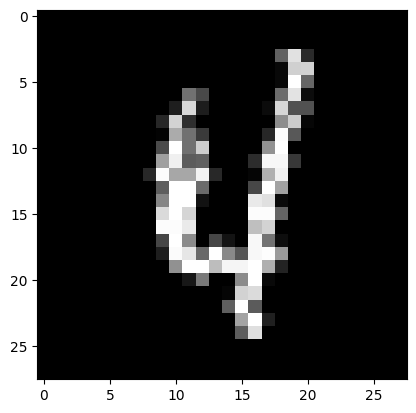

In [6]:
image , label = trainset[700]
plt.imshow(image.squeeze() , cmap = 'gray')

In [7]:
print('total images in trainsets : ' ,len(trainset))

total images in trainsets :  60000


# Dataset Into Batches

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


In [9]:
trainloader = DataLoader(trainset, batch_size= batch_size , shuffle= True)

In [10]:
print("total number of batches in trainloader", len(trainloader))

total number of batches in trainloader 469


In [11]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)


torch.Size([128, 1, 28, 28])


In [12]:
def show_tensor_images(tensor_img, num_images , size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

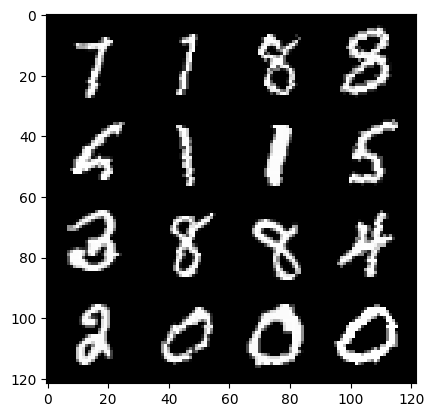

In [54]:
show_tensor_images(images, num_images=16)

# Discriminator Network

In [14]:
!pip install torchsummary

In [15]:
from torch import nn
from torchsummary import summary

In [16]:
def get_disc_block (in_channels, out_channels, kernel_size,stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [17]:
#disc_network
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.block_1 = get_disc_block (1, 16, (3,3), 2)
    self.block_2 = get_disc_block (16, 32, (5,5), 2)
    self.block_3 = get_disc_block (32, 64, (5,5), 2)
    self.Flatten = nn.Flatten()
    self.Linear = nn.Linear(in_features=64, out_features=1)
  def forward (self,images):
    x1 = self.block_1 (images)
    x2 = self.block_2 (x1)
    x3 = self.block_3 (x2)
    x4 = self.Flatten (x3)
    x5 = self.Linear (x4)

    return x5


In [18]:
D = Discriminator()
D.to(device)
summary (D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Generator Network

In [41]:
def get_gen_block (in_channels, out_channels, kernel_size,stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d (in_channels, out_channels, kernel_size,stride),
        nn.Tanh()
    )

  return nn.Sequential(
      nn.ConvTranspose2d (in_channels, out_channels, kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [47]:
#gen_network
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block (noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block (256, 128, (4,4), 1)
    self.block_3 = get_gen_block (128, 64, (3,3), 2)
    self.block_4 = get_gen_block (64, 1, (4,4), 2, final_block = True)
  def forward (self, r_noise_vec):
    #(bs,noise_dim) >> (bs, noise_dim, 1, 1)
    x = r_noise_vec.view (-1, self.noise_dim , 1 , 1)
    x1 = self.block_1 (x)
    x2 = self.block_2 (x1)
    x3 = self.block_3 (x2)
    x4 = self.block_4 (x3)
    return x4


In [48]:
G = Generator(noise_dim)
G.to(device)
summary (G, input_size=(1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [49]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [50]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Loss Function and Load Optimizer

In [51]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred , ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred , ground_truth)
  return loss

In [52]:
D_opt = torch.optim.Adam(D.parameters() , lr = lr, betas =(beta_1,beta_2))
G_opt = torch.optim.Adam(G.parameters() , lr = lr, betas =(beta_1,beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 1 : D_loss: 0.6820552426614741 , G_loss: 0.7069800968871696


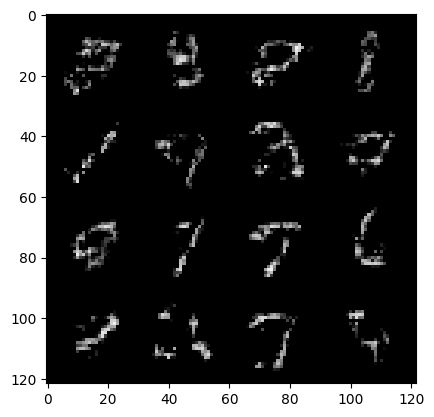

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 2 : D_loss: 0.6405427438109669 , G_loss: 0.7515932728232605


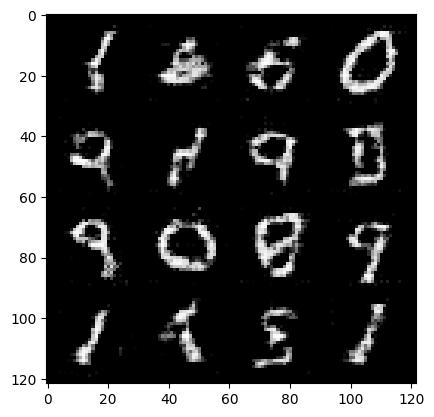

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 3 : D_loss: 0.6086482741176955 , G_loss: 0.7951329688527691


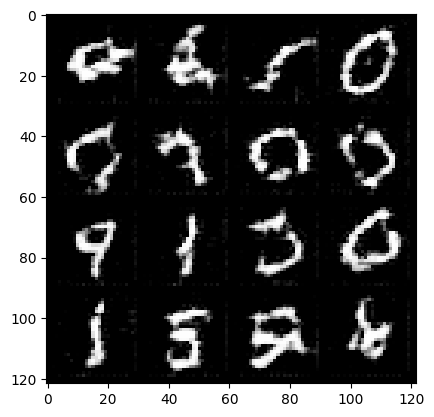

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 4 : D_loss: 0.5899288847502361 , G_loss: 0.8336891055361294


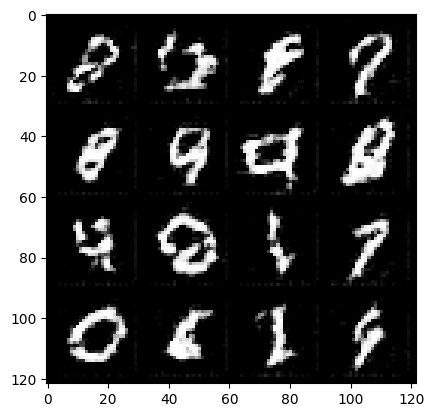

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 5 : D_loss: 0.5780214089066235 , G_loss: 0.8672298148496828


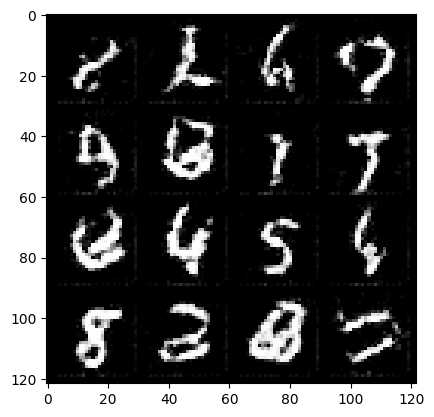

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 6 : D_loss: 0.5813667943228537 , G_loss: 0.8797250782757171


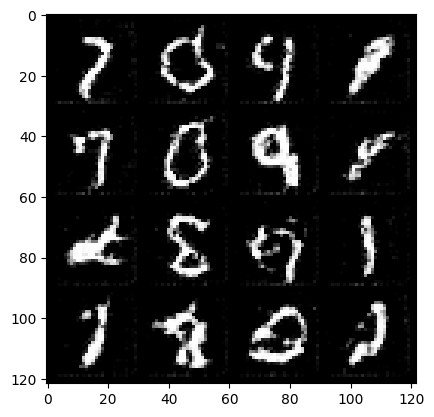

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 7 : D_loss: 0.5928077790528726 , G_loss: 0.8750998686625759


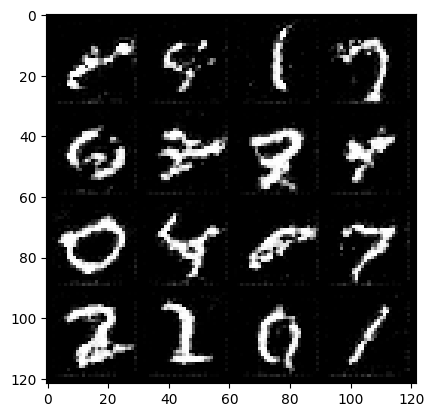

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 8 : D_loss: 0.6039032285401562 , G_loss: 0.8688524906823376


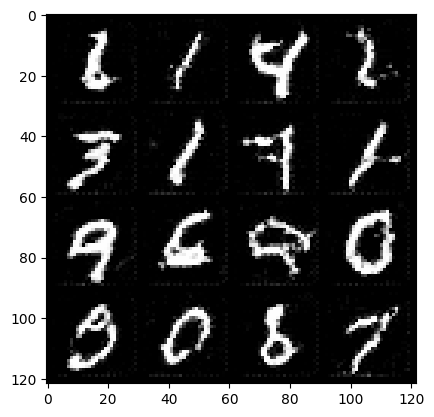

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 9 : D_loss: 0.6137908263755506 , G_loss: 0.8609864840121157


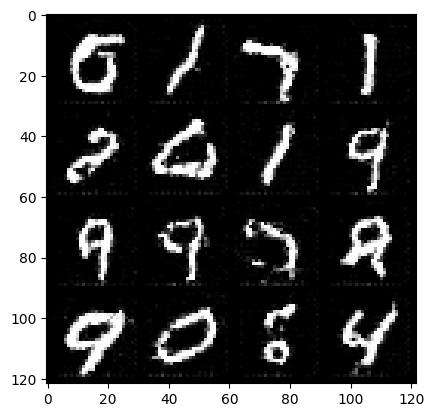

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 10 : D_loss: 0.6196847259362878 , G_loss: 0.8506304874603174


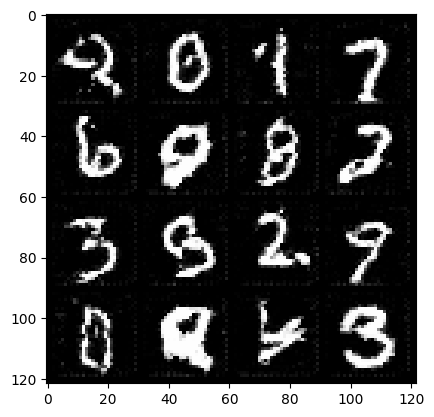

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 11 : D_loss: 0.6243184089406467 , G_loss: 0.8469954900650073


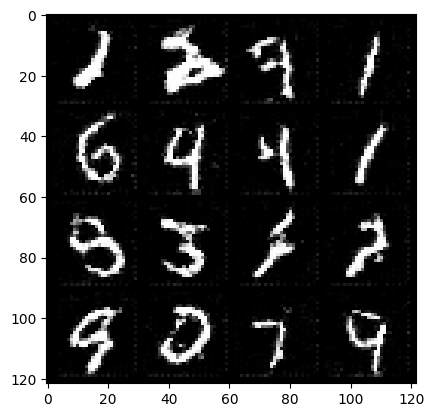

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 12 : D_loss: 0.6280639504572985 , G_loss: 0.8454855738926544


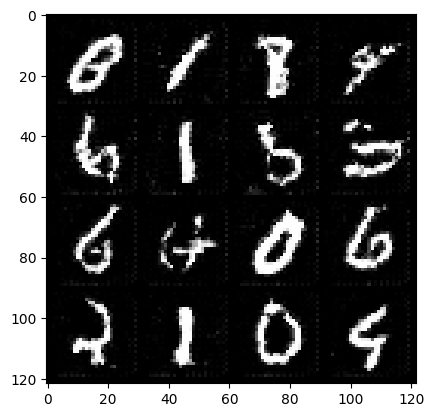

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 13 : D_loss: 0.6305442407949647 , G_loss: 0.8401355387559578


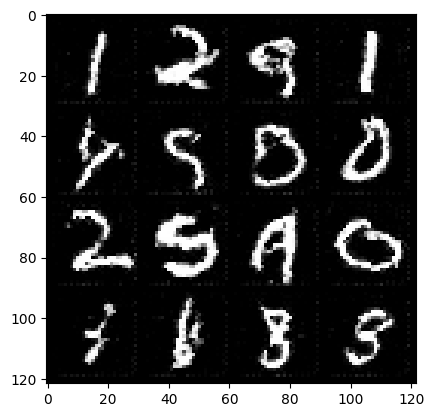

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 14 : D_loss: 0.6332177613843987 , G_loss: 0.8369115481752831


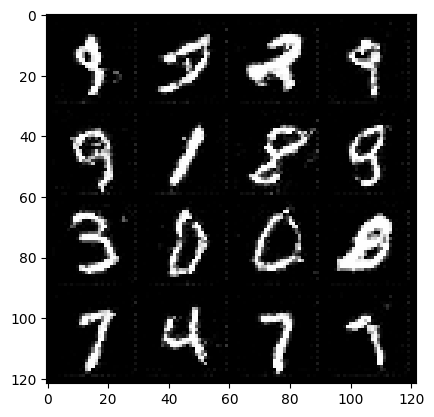

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 15 : D_loss: 0.6340328026682075 , G_loss: 0.8337019183742467


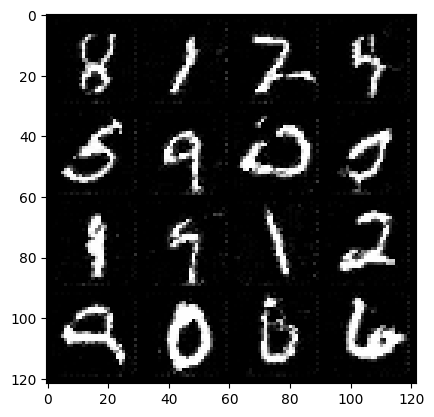

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 16 : D_loss: 0.6359025767362957 , G_loss: 0.8339244716965568


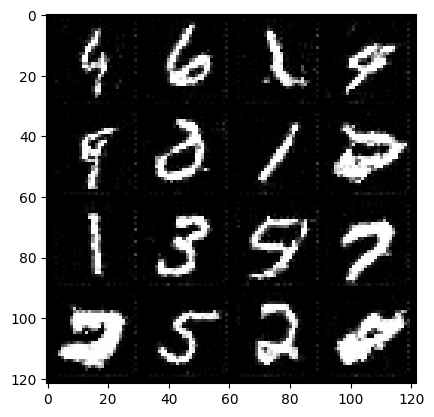

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 17 : D_loss: 0.6367040666690005 , G_loss: 0.8283844674065677


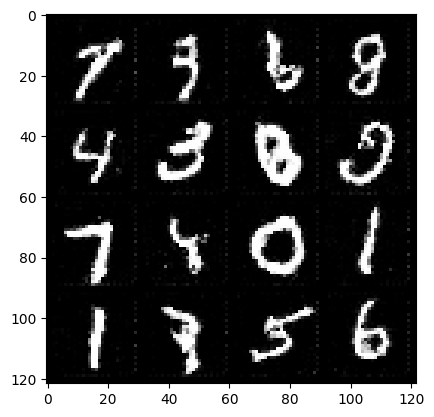

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 18 : D_loss: 0.6387327712481973 , G_loss: 0.8302904690252438


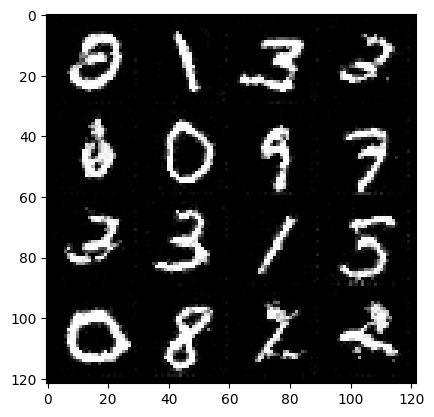

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 19 : D_loss: 0.63694281974581 , G_loss: 0.8295588977555476


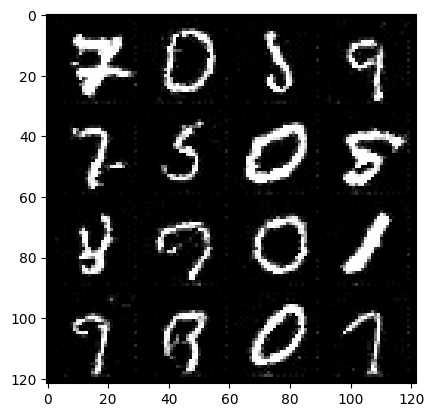

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 20 : D_loss: 0.6384225847370335 , G_loss: 0.8317000788412114


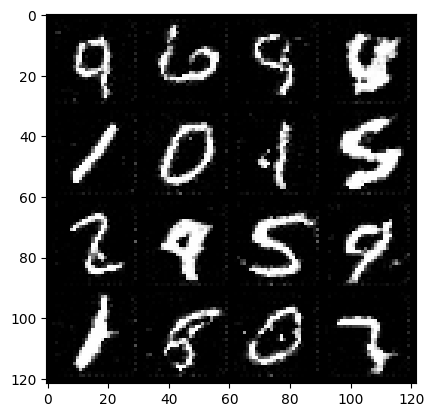

In [55]:
for i in range (epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0
  for real_img ,_ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size , noise_dim , device = device)
    #loss and updating weights for D
    D_opt.zero_grad()
    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss+D_real_loss) / 2
    total_d_loss += D_loss.item()
    D_loss.backward()
    D_opt.step()

    #loss and weights for G
    G_opt.zero_grad()
    noise = torch.randn(batch_size , noise_dim , device = device)
    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)
    total_g_loss += G_loss.item()
    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss /len(trainloader)
  avg_g_loss = total_g_loss /len(trainloader)

  print("epoch {} : D_loss: {} , G_loss: {}".format(i+1, avg_d_loss, avg_g_loss))
  show_tensor_images(fake_img,num_images=16)

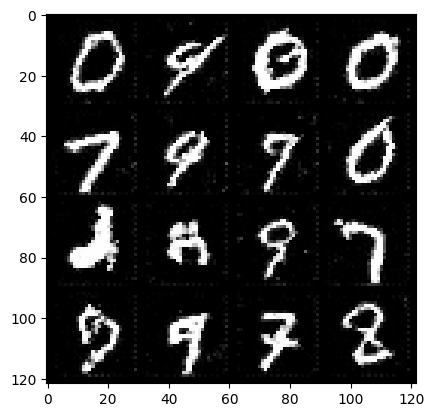

In [57]:
# Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image, num_images=16)